In [4]:
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.generalized_linear_model import GLM

import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

import multiprocessing as mp
from functools import partial

from permutation_weighting.estimator import PW as PW_estimator

class PW:
    """
    Probability Weighting class for estimating weights in causal inference
    """
    def __init__(self, outcome, features, n_bootstraps=10, model_type='glm'):
        """
        Initialize the probability weighting model

        Parameters:
        -----------
        outcome : array-like
            Binary treatment indicator
        features : array-like or DataFrame
            Covariates
        n_bootstraps : int
            Number of bootstrap iterations
        model_type : str
            Type of model to use ('glm' or 'boosting')
        """
        self.n_bootstraps = n_bootstraps
        self.model_type = model_type

        # Standardize features
        self.scaler = StandardScaler()
        if isinstance(features, pd.DataFrame):
            features_array = features.values
        else:
            features_array = features

        self.features_scaled = self.scaler.fit_transform(features_array)

        # Store data
        self.all_training_data = pd.DataFrame({
            'a': outcome
        })
        for i in range(self.features_scaled.shape[1]):
            self.all_training_data[f'X{i+1}'] = self.features_scaled[:, i]

        # Fit models
        self.models = []
        N = len(outcome)

        for _ in range(n_bootstraps):
            training_data = self._create_dataset(
                self.features_scaled, 
                outcome, 
                N
            )
            model = self._fit_pw(training_data)
            self.models.append(model)

    def _create_dataset(self, features, outcome, N):
        """Create permuted dataset for training"""
        sampled_ids = np.random.permutation(N)

        # Bootstrap samples
        bootstrap_idx = np.random.choice(N, size=N, replace=True)

        # Original data
        original_data = pd.DataFrame({
            'a': outcome[bootstrap_idx],
            'label': np.zeros(N)
        })
        for i in range(features.shape[1]):
            original_data[f'X{i+1}'] = features[bootstrap_idx, i]

        # Permuted data
        permuted_a = outcome[np.random.choice(N, size=N, replace=True)]
        permuted_x_idx = np.random.choice(N, size=N, replace=True)

        permuted_data = pd.DataFrame({
            'a': permuted_a,
            'label': np.ones(N)
        })
        for i in range(features.shape[1]):
            permuted_data[f'X{i+1}'] = features[permuted_x_idx, i]

        # Combine datasets
        training_data = pd.concat([original_data, permuted_data], ignore_index=True)
        return training_data

    def _fit_pw(self, df):
        """Fit probability weighting model"""
        if self.model_type == 'glm':
            # Create interaction terms
            feature_cols = [col for col in df.columns if col.startswith('X')]
            X = df[feature_cols].copy()

            # Add interactions with treatment
            for col in feature_cols:
                X[f'a_{col}'] = df['a'] * df[col]

            # Add treatment
            X['a'] = df['a']

            # Fit model
            model = LogisticRegression(
                penalty='l2',
                solver='newton-cg',
                max_iter=1000
            )
            model.fit(X, df['label'])
            return {
                'model': model,
                'feature_cols': feature_cols
            }

        elif self.model_type == 'boosting':
            # Create interaction terms
            feature_cols = [col for col in df.columns if col.startswith('X')]
            X = df[feature_cols].copy()

            # Add interactions with treatment
            for col in feature_cols:
                X[f'a_{col}'] = df['a'] * df[col]

            # Add treatment
            X['a'] = df['a']

            # Fit model
            model = GradientBoostingClassifier(
                n_estimators=1000,
                learning_rate=0.05,
                max_depth=3
            )
            model.fit(X, df['label'])
            return {
                'model': model,
                'feature_cols': feature_cols
            }
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")

    def predict(self, outcome=None, features=None):
        """
        Predict weights

        Parameters:
        -----------
        outcome : array-like, optional
            Treatment indicators for new data
        features : array-like or DataFrame, optional
            Covariates for new data

        Returns:
        --------
        array
            Weights for each observation
        """
        if outcome is None and features is None:
            test_data = self.all_training_data
        elif outcome is not None and features is not None:
            # Scale new features
            if isinstance(features, pd.DataFrame):
                features_array = features.values
            else:
                features_array = features

            features_scaled = self.scaler.transform(features_array)

            # Create dataframe
            test_data = pd.DataFrame({
                'a': outcome
            })
            for i in range(features_scaled.shape[1]):
                test_data[f'X{i+1}'] = features_scaled[:, i]
        else:
            raise ValueError("Either both or neither outcome and features must be provided.")

        # Get predictions from all models
        all_preds = []
        for model_info in self.models:
            model = model_info['model']
            feature_cols = model_info['feature_cols']

            # Create interaction terms
            X = test_data[feature_cols].copy()

            # Add interactions with treatment
            for col in feature_cols:
                X[f'a_{col}'] = test_data['a'] * test_data[col]

            # Add treatment
            X['a'] = test_data['a']

            # Predict
            preds = model.predict_proba(X)[:, 1]
            weights = preds / (1 - preds)
            all_preds.append(np.log(weights))

        # Average predictions
        return np.exp(np.mean(np.column_stack(all_preds), axis=1))

def create_dataset(features, outcome, N):
    """Utility function to create dataset for training"""
    pw = PW(outcome, features, n_bootstraps=1)
    return pw._create_dataset(
        pw.features_scaled, 
        outcome, 
        N
    )

def create_kang_schafer_dgp(n, misspecified=False, extraneous_covs=0):
    """
    Creates the Kang-Schafer data generating process.
    
    Parameters:
    -----------
    n : int
        Sample size
    misspecified : bool
        Whether to use the misspecified model
    extraneous_covs : int
        Number of extra covariates to include
    
    Returns:
    --------
    dict
        A dictionary with data and functions for simulation
    """
    # Generate covariates
    np.random.seed(42)  # For reproducibility
    X = stats.multivariate_normal.rvs(
        mean=np.zeros(4 + extraneous_covs), 
        cov=np.eye(4 + extraneous_covs), 
        size=n
    )
    
    # True propensity score
    logit = X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]
    prop = 1 / (1 + np.exp(logit))
    
    # True outcome
    Outcome = 210 + 27.4 * X[:, 0] + 13.7 * X[:, 1] + 13.7 * X[:, 2] + 13.7 * X[:, 3]
    
    # Outcome noise
    outcome_noise = np.random.normal(size=n)
    
    def draw_dose():
        """Draw treatment assignment based on propensity score"""
        return np.random.binomial(1, prop, n)
    
    def draw_outcome(A):
        """Draw outcome based on treatment and baseline covariates"""
        return Outcome + A + outcome_noise
    
    # Create observed covariates (potentially misspecified)
    if misspecified:
        X_df = {
            'X1': np.exp(X[:, 0] / 2),
            'X2': X[:, 1] * (1 + np.exp(X[:, 0])) ** (-1) + 10,
            'X3': (X[:, 0] * X[:, 2] / 25 + 0.6) ** 3,
            'X4': (X[:, 1] + X[:, 3] + 20) ** 2
        }
        
        if extraneous_covs > 0:
            for i in range(5, 5 + extraneous_covs):
                X_df[f'X{i}'] = X[:, i-1]
    else:
        X_df = {f'X{i+1}': X[:, i] for i in range(X.shape[1])}
    
    # Convert to a more structured format
    output = {
        'draw_dose': draw_dose,
        'draw_outcome': draw_outcome,
        'prob_treatment': [0.5, 0.5],
        'data': X_df,
        'ps_formula': 'Dose ~ ' + '+'.join([f'X{i+1}' for i in range(X.shape[1])]),
        'X_formula': '~ 0+' + '+'.join([f'X{i+1}' for i in range(X.shape[1])]),
        'all_formula': '~ 0+Dose+' + '+'.join([f'X{i+1}' for i in range(X.shape[1])]),
        'outcome_formula': 'Outcome ~ Dose',
        'full_outcome_formula': 'Outcome ~ Dose+' + '+'.join([f'X{i+1}' for i in range(X.shape[1])])
    }
    
    return output


def perform_binary_simulation(
    dgp,
    models_for_pw=['logit', 'boosting', 'sgd','mlp'],
    weighting_estimators=['ps', 'sbw', 'gbm', 'cbps'],
    extra_args={'cbps': {'over': True}}
):
    """
    Perform binary treatment simulation
    
    Parameters:
    -----------
    dgp : dict
        Data generating process dictionary
    models_for_pw : list
        List of models to use for probability weighting
    weighting_estimators : list
        List of weighting estimators to use
    extra_args : dict
        Extra arguments for specific estimators
        
    Returns:
    --------
    DataFrame
        Results of the simulation
    """
    #from weighting_class import PW
    
    # Get formulas and data
    ps_formula = dgp['ps_formula']
    X_formula = dgp['X_formula']
    full_outcome_formula = dgp['full_outcome_formula']
    
    # Create data frame
    df = pd.DataFrame(dgp['data'])
    df['Dose'] = dgp['draw_dose']()
    df['Outcome'] = dgp['draw_outcome'](df['Dose'])
    
    # Get X matrix for treatment model
    X_cols = [col for col in df.columns if col.startswith('X')]
    X_for_dose = df[X_cols]
    
    # Timing dictionary
    timings = {}
    results = []
    
    # PW weights
    pw_weights = {}
    for model in models_for_pw:
        model_id = f'PW-{model}'
        print(model_id)
        start_time = time.time()
        
        try:
            pw_mod = PW_estimator(df['Dose'].values, X_for_dose.values, classifier=model)
            pw_weights[model_id] = pw_mod['weights']
        except Exception as e:
            print(f"Error in {model_id}: {e}")
            pw_weights[model_id] = np.ones(len(df)) * np.nan
            
        timings[model_id] = time.time() - start_time
        print('done')
    
    # Non-PW weights
    nonpw_weights = {}
    
    # Here we would implement various weighting estimators
    # For simplicity, I'll implement a basic propensity score model
    # and leave placeholders for the other methods
    
    # Basic propensity score model
    if 'ps' in weighting_estimators:
        print('ps')
        start_time = time.time()
        
        try:
            # Fit propensity score model
            ps_model = GLM(
                df['Dose'], 
                sm.add_constant(X_for_dose), 
                family=Binomial()
            ).fit()
            
            # Get propensity scores
            ps = ps_model.predict()
            
            # Calculate inverse probability weights
            w = np.zeros(len(df))
            w[df['Dose'] == 1] = 1 / ps[df['Dose'] == 1]
            w[df['Dose'] == 0] = 1 / (1 - ps[df['Dose'] == 0])
            
            # Stabilize weights
            w_treated = w[df['Dose'] == 1]
            w_control = w[df['Dose'] == 0]
            
            # Normalize by the mean weight within each treatment group
            w[df['Dose'] == 1] = w_treated / np.mean(w_treated)
            w[df['Dose'] == 0] = w_control / np.mean(w_control)
            
            nonpw_weights['ps'] = w
        except Exception as e:
            print(f"Error in ps: {e}")
            nonpw_weights['ps'] = np.ones(len(df)) * np.nan
            
        timings['ps'] = time.time() - start_time
        print('done')
    
    # Placeholder for other methods
    for method in set(weighting_estimators) - {'ps'}:
        print(method)
        nonpw_weights[method] = np.ones(len(df)) * np.nan
        timings[method] = 0
        print('done')
    
    # Add unweighted estimator
    nonpw_weights['Unweighted'] = np.ones(len(df))
    
    print('Done estimating weights.')
    print('Estimating accuracy on empirical sample...')
    
    # Combine all weights
    all_weights = {**pw_weights, **nonpw_weights}
    
    # Helper function to get difference
    def get_difference(estimates, truth, wts=None):
        if wts is None:
            wts = np.ones(len(df))
            
        # Group by treatment
        truth_by_trt = pd.DataFrame({
            'est': truth,
            'D': df['Dose']
        }).groupby('D').agg({'est': 'mean'})
        
        estimates_by_trt = pd.DataFrame({
            'est': estimates,
            'w': wts,
            'D': df['Dose']
        }).groupby('D').apply(lambda x: np.average(x['est'], weights=x['w']))
        
        # Calculate difference
        return (estimates_by_trt - truth_by_trt['est']).values
    
    # Loop through all weighting methods
    for w_name, wt in all_weights.items():
        # Skip if weights are NA
        if np.any(np.isnan(wt)):
            results.append({
                'weighting': w_name,
                'metric': 'difference',
                'estimator': 'DM',
                'model': 'OLS',
                'loc': 0,
                'value': np.nan
            })
            continue
        
        # Normalize weights to sum to n
        wt = wt / np.sum(wt) * len(df)
        
        # Direct method with OLS
        ols_y_model = LinearRegression()
        X = np.column_stack([df['Dose'].values[:, np.newaxis], df[X_cols].values])
        ols_y_model.fit(X, df['Outcome'], sample_weight=wt)
        
        # Direct method with Random Forest
        rf_y_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_y_model.fit(X, df['Outcome'], sample_weight=wt)
        
        # Calculate DM estimates for each treatment level
        dm_overall = []
        
        for dose in [0, 1]:
            # Create new dataframe with the specified treatment
            dm_df = df.copy()
            dm_df['Dose'] = dose
            
            # Create design matrix for prediction
            X_pred = np.column_stack([dm_df['Dose'].values[:, np.newaxis], dm_df[X_cols].values])
            
            # Get predictions
            ols_dm = ols_y_model.predict(X_pred).mean()
            rf_dm = rf_y_model.predict(X_pred).mean()
            
            # Get true outcome
            truth = np.mean(dgp['draw_outcome'](np.repeat(dose, len(df))))
            
            dm_overall.append({
                'OLS': ols_dm,
                'RF': rf_dm,
                'TRUTH': truth,
                'Dose': dose
            })
        
        # Convert to dictionary for easy access
        dm_overall_df = pd.DataFrame(dm_overall)
        ols_overall = {dose: val for dose, val in zip(dm_overall_df['Dose'], dm_overall_df['OLS'])}
        rf_overall = {dose: val for dose, val in zip(dm_overall_df['Dose'], dm_overall_df['RF'])}
        truth_overall = {dose: val for dose, val in zip(dm_overall_df['Dose'], dm_overall_df['TRUTH'])}
        
        # Get truth values for each observation
        truth = np.array([truth_overall[dose] for dose in df['Dose']])
        
        # Get DM predictions for each observation
        dm_ols_avg = np.array([ols_overall[dose] for dose in df['Dose']])
        dm_rf_avg = np.array([rf_overall[dose] for dose in df['Dose']])
        
        # Calculate actual DM predictions for each datapoint
        dm_ols = ols_y_model.predict(X)
        dm_rf = rf_y_model.predict(X)
        
        # Calculate doubly-robust estimators
        dr_ols = dm_ols_avg + (df['Outcome'] - dm_ols) * wt
        dr_rf = dm_rf_avg + (df['Outcome'] - dm_rf) * wt
        
        # Calculate differences for each estimator and model
        for estimator, model, values in [
            ('DM', 'OLS', dm_ols_avg),
            ('DM', 'RF', dm_rf_avg),
            ('DR', 'OLS', dr_ols),
            ('DR', 'RF', dr_rf),
            ('SIPW', None, df['Outcome'])
        ]:
            diff = get_difference(values, truth, wt if estimator == 'SIPW' else None)
            
            for loc, val in enumerate(diff):
                results.append({
                    'samplesize': len(df),
                    'weighting': w_name,
                    'metric': 'difference',
                    'estimator': estimator,
                    'model': model,
                    'loc': loc,
                    'value': val
                })
    
    # Add timing results
    for w_name, timing in timings.items():
        results.append({
            'samplesize': len(df),
            'weighting': w_name,
            'metric': 'Runtime',
            'estimator': None,
            'model': None,
            'loc': None,
            'value': timing
        })
    
    return pd.DataFrame(results)

def run_single_simulation(n, spec, sim_idx, extra_covs=0):
    """Run a single simulation"""
    print(f"Running simulation {sim_idx}: n={n}, misspecified={spec}")
    np.random.seed(100 + sim_idx)  # Ensure reproducibility but different across sims
    
    dgp = create_kang_schafer_dgp(n, misspecified=spec, extraneous_covs=extra_covs)
    
    # Run simulation
    result = perform_binary_simulation(dgp)
    
    # Add metadata
    result['iter'] = sim_idx
    result['specification'] = spec
    
    return result

def run_kang_schafer_simulation(
    sample_sizes=[100, 250, 500, 1000, 2000, 3500, 5000, 10000],
    specifications=[True, False],
    n_simulations=48,
    extra_covs=0,
    use_parallel=True,
    n_cores=None
):
    """
    Run the Kang-Schafer simulation study
    
    Parameters:
    -----------
    sample_sizes : list
        List of sample sizes to simulate
    specifications : list
        List of misspecification flags
    n_simulations : int
        Number of simulations to run
    extra_covs : int
        Number of extra covariates
    use_parallel : bool
        Whether to use parallel processing
    n_cores : int
        Number of cores to use (if None, use all available)
        
    Returns:
    --------
    DataFrame
        Combined results from all simulations
    """
    # Start timing
    start_time = time.time()
    
    # Create all parameter combinations
    params = []
    for spec in specifications:
        for n in sample_sizes:
            for sim_idx in range(n_simulations):
                params.append((n, spec, sim_idx, extra_covs))
    
    # Run simulations
    if use_parallel:
        if n_cores is None:
            n_cores = mp.cpu_count()
        
        print(f"Running in parallel with {n_cores} cores")
        with mp.Pool(n_cores) as pool:
            simulation_func = partial(run_single_simulation)
            results = pool.starmap(simulation_func, params)
    else:
        print("Running sequentially")
        results = []
        for param in params:
            results.append(run_single_simulation(*param))
    
    # Combine results
    combined_results = pd.concat(results, ignore_index=True)
    
    # Report timing
    elapsed_time = time.time() - start_time
    print(f"Simulations completed in {elapsed_time:.2f} seconds")
    
    return combined_results

def bootstrap_irmse_binary(df, prob_treatment=[0.5, 0.5], B=100):
    """
    Bootstrap integrated RMSE for binary treatment
    
    Parameters:
    -----------
    df : DataFrame
        Results from simulation
    prob_treatment : list
        Probability of each treatment
    B : int
        Number of bootstrap iterations
        
    Returns:
    --------
    DataFrame
        Bootstrap results
    """
    # Ensure all needed columns exist
    required_cols = ['iter', 'metric', 'samplesize', 'weighting', 'estimator', 'model', 'loc', 'value']
    for col in required_cols:
        if col not in df.columns:
            print(f"Missing column: {col}")
            print(f"Available columns: {df.columns.tolist()}")
            # Create a basic result with minimal columns if missing key columns
            if col in ['samplesize', 'weighting', 'estimator', 'model']:
                # Create minimal DataFrame with just the essential columns
                return pd.DataFrame({
                    'samplesize': [df['samplesize'].iloc[0] if 'samplesize' in df.columns else 0],
                    'weighting': [df['weighting'].iloc[0] if 'weighting' in df.columns else 'unknown'],
                    'estimator': [df['estimator'].iloc[0] if 'estimator' in df.columns else 'unknown'],
                    'model': [df['model'].iloc[0] if 'model' in df.columns else 'unknown'],
                    'sem': [0],
                    'value': [0]
                })
    
    # Filter for difference metric
    if 'metric' in df.columns:
        df = df[df['metric'] == 'difference'].copy()
    
    # Handle single iteration case or empty DataFrame
    if 'iter' not in df.columns or len(df['iter'].unique()) <= 1 or len(df) == 0:
        print("Using direct calculation (no bootstrapping)")
        # Calculate RMSE directly
        results_summary = []
        
        # Group by all grouping variables that exist
        groupby_cols = []
        for col in ['samplesize', 'weighting', 'estimator', 'model', 'loc']:
            if col in df.columns:
                groupby_cols.append(col)
        
        if not groupby_cols or 'value' not in df.columns:
            # No valid grouping or values
            return pd.DataFrame({
                'samplesize': [0],
                'weighting': ['unknown'],
                'estimator': ['unknown'],
                'model': ['unknown'],
                'sem': [0],
                'value': [0]
            })
            
        # Calculate RMSE
        rmse_df = []
        for name, group in df.groupby(groupby_cols):
            # Create a dict from the group keys
            result = {}
            for i, col in enumerate(groupby_cols):
                # Handle case where name is not a tuple (single group)
                if isinstance(name, tuple):
                    result[col] = name[i]
                else:
                    result[col] = name
            
            # Add treatment_loc (rename loc to avoid conflicts)
            if 'loc' in result:
                result['treatment_loc'] = result.pop('loc')
            
            # Calculate RMSE
            result['rmse'] = np.sqrt(np.mean(group['value']**2))
            rmse_df.append(result)
        
        if not rmse_df:
            return pd.DataFrame({
                'samplesize': [0],
                'weighting': ['unknown'],
                'estimator': ['unknown'],
                'model': ['unknown'],
                'sem': [0],
                'value': [0]
            })
            
        rmse_by_group = pd.DataFrame(rmse_df)
        
        # Calculate integrated RMSE
        irmse_df = []
        
        # Group by all columns except treatment_loc
        group_cols = [col for col in rmse_by_group.columns if col != 'treatment_loc' and col != 'rmse']
        
        for name, group in rmse_by_group.groupby(group_cols):
            result = {}
            
            # Handle case where name is not a tuple (single group)
            if isinstance(name, tuple):
                for i, col in enumerate(group_cols):
                    result[col] = name[i]
            else:
                # If there's only one grouping column
                result[group_cols[0]] = name
                
            # Calculate weighted average using treatment probabilities
            weights = []
            for loc in group['treatment_loc']:
                try:
                    # Handle int or string location
                    loc_idx = int(loc)
                    if loc_idx < len(prob_treatment):
                        weights.append(prob_treatment[loc_idx])
                    else:
                        weights.append(1.0)
                except (ValueError, TypeError):
                    weights.append(1.0)
            
            result['value'] = np.average(group['rmse'], weights=weights)
            result['sem'] = 0  # No variation with single iteration
            irmse_df.append(result)
            
        if not irmse_df:
            return pd.DataFrame({
                'samplesize': [0],
                'weighting': ['unknown'],
                'estimator': ['unknown'],
                'model': ['unknown'],
                'sem': [0],
                'value': [0]
            })
            
        return pd.DataFrame(irmse_df)
    
    # For multiple iterations, do bootstrapping
    print(f"Bootstrapping with {B} iterations")
    results = []
    
    for b in range(B):
        # Sample iterations with replacement
        iters_to_use = np.random.choice(df['iter'].unique(), size=len(df['iter'].unique()), replace=True)
        
        # Combine all rows
        bootstrap_df = pd.concat([df[df['iter'] == it] for it in iters_to_use])
        
        # Calculate RMSE by treatment group
        rmse_df = []
        for name, group in bootstrap_df.groupby(['samplesize', 'weighting', 'estimator', 'model', 'loc']):
            rmse_df.append({
                'samplesize': name[0],
                'weighting': name[1],
                'estimator': name[2],
                'model': name[3],
                'treatment_loc': name[4],  # Rename to avoid conflict
                'rmse': np.sqrt(np.mean(group['value']**2))
            })
        
        if not rmse_df:
            continue
            
        rmse_by_group = pd.DataFrame(rmse_df)
        
        # Calculate integrated RMSE
        irmse_df = []
        for name, group in rmse_by_group.groupby(['samplesize', 'weighting', 'estimator', 'model']):
            weights = []
            for loc in group['treatment_loc']:
                try:
                    loc_idx = int(loc)
                    if loc_idx < len(prob_treatment):
                        weights.append(prob_treatment[loc_idx])
                    else:
                        weights.append(1.0)
                except (ValueError, TypeError):
                    weights.append(1.0)
                    
            irmse_df.append({
                'samplesize': name[0],
                'weighting': name[1],
                'estimator': name[2],
                'model': name[3],
                'irmse': np.average(group['rmse'], weights=weights)
            })
        
        if irmse_df:
            results.append(pd.DataFrame(irmse_df))
    
    # Combine results and calculate mean and standard error
    if not results:
        return pd.DataFrame({
            'samplesize': [0],
            'weighting': ['unknown'],
            'estimator': ['unknown'],
            'model': ['unknown'],
            'sem': [0],
            'value': [0]
        })
        
    bootstrap_df = pd.concat(results, ignore_index=True)
    
    # Manual calculation of mean and standard error
    results_summary = []
    for name, group in bootstrap_df.groupby(['samplesize', 'weighting', 'estimator', 'model']):
        results_summary.append({
            'samplesize': name[0],
            'weighting': name[1],
            'estimator': name[2],
            'model': name[3],
            'sem': np.std(group['irmse']),
            'value': np.mean(group['irmse'])
        })
    
    return pd.DataFrame(results_summary)

def bootstrap_bias_binary(df, prob_treatment=[0.5, 0.5], B=100):
    """
    Bootstrap integrated bias for binary treatment
    
    Parameters:
    -----------
    df : DataFrame
        Results from simulation
    prob_treatment : list
        Probability of each treatment
    B : int
        Number of bootstrap iterations
        
    Returns:
    --------
    DataFrame
        Bootstrap results
    """
    # Ensure all needed columns exist
    required_cols = ['iter', 'metric', 'samplesize', 'weighting', 'estimator', 'model', 'loc', 'value']
    for col in required_cols:
        if col not in df.columns:
            print(f"Missing column: {col}")
            print(f"Available columns: {df.columns.tolist()}")
            # Create a basic result with minimal columns if missing key columns
            if col in ['samplesize', 'weighting', 'estimator', 'model']:
                # Create minimal DataFrame with just the essential columns
                return pd.DataFrame({
                    'samplesize': [df['samplesize'].iloc[0] if 'samplesize' in df.columns else 0],
                    'weighting': [df['weighting'].iloc[0] if 'weighting' in df.columns else 'unknown'],
                    'estimator': [df['estimator'].iloc[0] if 'estimator' in df.columns else 'unknown'],
                    'model': [df['model'].iloc[0] if 'model' in df.columns else 'unknown'],
                    'sem': [0],
                    'value': [0]
                })

    # Filter for difference metric
    if 'metric' in df.columns:
        df = df[df['metric'] == 'difference'].copy()
    
    # Handle single iteration case or empty DataFrame
    if 'iter' not in df.columns or len(df['iter'].unique()) <= 1 or len(df) == 0:
        print("Using direct calculation (no bootstrapping)")
        # Calculate bias directly
        results_summary = []
        
        # Group by all grouping variables that exist
        groupby_cols = []
        for col in ['samplesize', 'weighting', 'estimator', 'model', 'loc']:
            if col in df.columns:
                groupby_cols.append(col)
        
        if not groupby_cols or 'value' not in df.columns:
            # No valid grouping or values
            return pd.DataFrame({
                'samplesize': [0],
                'weighting': ['unknown'],
                'estimator': ['unknown'],
                'model': ['unknown'],
                'sem': [0],
                'value': [0]
            })
            
        # Calculate bias
        bias_df = []
        for name, group in df.groupby(groupby_cols):
            # Create a dict from the group keys
            result = {}
            for i, col in enumerate(groupby_cols):
                # Handle case where name is not a tuple (single group)
                if isinstance(name, tuple):
                    result[col] = name[i]
                else:
                    result[col] = name
            
            # Add treatment_loc (rename loc to avoid conflicts)
            if 'loc' in result:
                result['treatment_loc'] = result.pop('loc')
            
            # Calculate bias
            result['bias'] = np.abs(np.mean(group['value']))
            bias_df.append(result)
        
        if not bias_df:
            return pd.DataFrame({
                'samplesize': [0],
                'weighting': ['unknown'],
                'estimator': ['unknown'],
                'model': ['unknown'],
                'sem': [0],
                'value': [0]
            })
            
        bias_by_group = pd.DataFrame(bias_df)
        
        # Calculate integrated bias
        ibias_df = []
        
        # Group by all columns except treatment_loc
        group_cols = [col for col in bias_by_group.columns if col != 'treatment_loc' and col != 'bias']
        
        for name, group in bias_by_group.groupby(group_cols):
            result = {}
            
            # Handle case where name is not a tuple (single group)
            if isinstance(name, tuple):
                for i, col in enumerate(group_cols):
                    result[col] = name[i]
            else:
                # If there's only one grouping column
                result[group_cols[0]] = name
                
            # Calculate weighted average using treatment probabilities
            weights = []
            for loc in group['treatment_loc']:
                try:
                    # Handle int or string location
                    loc_idx = int(loc)
                    if loc_idx < len(prob_treatment):
                        weights.append(prob_treatment[loc_idx])
                    else:
                        weights.append(1.0)
                except (ValueError, TypeError):
                    weights.append(1.0)
            
            result['value'] = np.average(group['bias'], weights=weights)
            result['sem'] = 0  # No variation with single iteration
            ibias_df.append(result)
            
        if not ibias_df:
            return pd.DataFrame({
                'samplesize': [0],
                'weighting': ['unknown'],
                'estimator': ['unknown'],
                'model': ['unknown'],
                'sem': [0],
                'value': [0]
            })
            
        return pd.DataFrame(ibias_df)
    
    # For multiple iterations, do bootstrapping
    print(f"Bootstrapping with {B} iterations")
    results = []
    
    for b in range(B):
        # Sample iterations with replacement
        iters_to_use = np.random.choice(df['iter'].unique(), size=len(df['iter'].unique()), replace=True)
        
        # Combine all rows
        bootstrap_df = pd.concat([df[df['iter'] == it] for it in iters_to_use])
        
        # Calculate bias by treatment group
        bias_df = []
        for name, group in bootstrap_df.groupby(['samplesize', 'weighting', 'estimator', 'model', 'loc']):
            bias_df.append({
                'samplesize': name[0],
                'weighting': name[1],
                'estimator': name[2],
                'model': name[3],
                'treatment_loc': name[4],  # Rename to avoid conflict
                'bias': np.abs(np.mean(group['value']))
            })
        
        if not bias_df:
            continue
            
        bias_by_group = pd.DataFrame(bias_df)
        
        # Calculate integrated bias
        ibias_df = []
        for name, group in bias_by_group.groupby(['samplesize', 'weighting', 'estimator', 'model']):
            weights = []
            for loc in group['treatment_loc']:
                try:
                    loc_idx = int(loc)
                    if loc_idx < len(prob_treatment):
                        weights.append(prob_treatment[loc_idx])
                    else:
                        weights.append(1.0)
                except (ValueError, TypeError):
                    weights.append(1.0)
                    
            ibias_df.append({
                'samplesize': name[0],
                'weighting': name[1],
                'estimator': name[2],
                'model': name[3],
                'ibias': np.average(group['bias'], weights=weights)
            })
        
        if ibias_df:
            results.append(pd.DataFrame(ibias_df))
    
    # Combine results and calculate mean and standard error
    if not results:
        return pd.DataFrame({
            'samplesize': [0],
            'weighting': ['unknown'],
            'estimator': ['unknown'],
            'model': ['unknown'],
            'sem': [0],
            'value': [0]
        })
        
    bootstrap_df = pd.concat(results, ignore_index=True)
    
    # Manual calculation of mean and standard error
    results_summary = []
    for name, group in bootstrap_df.groupby(['samplesize', 'weighting', 'estimator', 'model']):
        results_summary.append({
            'samplesize': name[0],
            'weighting': name[1],
            'estimator': name[2],
            'model': name[3],
            'sem': np.std(group['ibias']),
            'value': np.mean(group['ibias'])
        })
    
    return pd.DataFrame(results_summary)

def bootstrap_metrics(data, dgp, metric_type='both', bootstrap_iterations=100):
    """
    Bootstrap metrics (IRMSE and/or IMAB) from simulation data
    
    Parameters:
    -----------
    data : DataFrame
        Simulation results filtered for a specific estimator, weighting method, and sample size
    dgp : dict
        Data generating process dictionary with treatment probabilities
    metric_type : str
        'rmse', 'bias', or 'both' to determine which metric(s) to calculate
    bootstrap_iterations : int
        Number of bootstrap iterations
        
    Returns:
    --------
    dict
        Dictionary with mean and standard error for requested metrics
    """
    results = {}
    
    unique_iterations = data['iter'].unique()
    
    # Bootstrap at the iteration level
    irmse_values = []
    imab_values = []
    
    for _ in range(bootstrap_iterations):
        # Sample iterations with replacement
        bootstrap_iters = np.random.choice(unique_iterations, size=len(unique_iterations), replace=True)
        
        # Collect data for these iterations
        bootstrap_samples = []
        for it in bootstrap_iters:
            iter_data = data[data['iter'] == it]
            if len(iter_data) > 0:
                bootstrap_samples.append(iter_data)
        
        if not bootstrap_samples:
            continue
            
        bootstrap_data = pd.concat(bootstrap_samples)
        
        # Group by treatment location
        by_loc = bootstrap_data.groupby('loc')
        
        # Calculate metrics
        if metric_type in ['rmse', 'both']:
            rmse_by_loc = by_loc.apply(lambda x: np.sqrt(np.mean(x['value']**2)))
            
            # Weighted average using treatment probabilities
            if 'prob_treatment' in dgp and len(dgp['prob_treatment']) >= len(rmse_by_loc):
                weights = [dgp['prob_treatment'][int(loc)] for loc in rmse_by_loc.index]
                irmse = np.average(rmse_by_loc, weights=weights)
            else:
                irmse = rmse_by_loc.mean()
            
            irmse_values.append(irmse)
        
        if metric_type in ['bias', 'both']:
            mab_by_loc = by_loc.apply(lambda x: np.abs(np.mean(x['value'])))
            
            if 'prob_treatment' in dgp and len(dgp['prob_treatment']) >= len(mab_by_loc):
                weights = [dgp['prob_treatment'][int(loc)] for loc in mab_by_loc.index]
                imab = np.average(mab_by_loc, weights=weights)
            else:
                imab = mab_by_loc.mean()
            
            imab_values.append(imab)
    
    # Calculate statistics from bootstrap samples
    if metric_type in ['rmse', 'both'] and irmse_values:
        results['irmse_mean'] = np.mean(irmse_values)
        results['irmse_se'] = np.std(irmse_values)
    
    if metric_type in ['bias', 'both'] and imab_values:
        results['imab_mean'] = np.mean(imab_values)
        results['imab_se'] =np.std(imab_values)
            
    
    
    return results

def create_metrics_plot(results, dgp, focus_on='SIPW', bootstrap_iterations=100):
    """
    Create a plot showing IRMSE and IMAB metrics by sample size
    
    Parameters:
    -----------
    results : DataFrame
        Simulation results
    dgp : dict
        Data generating process dictionary
    focus_on : str
        Which estimator to focus on (default 'SIPW')
    bootstrap_iterations : int
        Number of bootstrap iterations
        
    Returns:
    --------
    tuple
        (figure, plot_data)
    """
    # Filter data for our focus estimator
    focus_data = results[
        (results['estimator'] == focus_on) & 
        (results['metric'] == 'difference')
    ].copy()
    
    if len(focus_data) == 0:
        return None, None
    
    # Get sample sizes and weighting methods
    sample_sizes = sorted(focus_data['samplesize'].unique())
    weighting_methods = focus_data['weighting'].unique()
    
    # Create color map
    n_colors = len(weighting_methods)
    colors = sns.color_palette("tab10", n_colors) if n_colors <= 10 else sns.color_palette("husl", n_colors)
    color_map = dict(zip(weighting_methods, colors))
    
    # Calculate metrics with bootstrapping
    metrics_data = []
    
    for size in sample_sizes:
        size_data = focus_data[focus_data['samplesize'] == size]
        
        for weight in weighting_methods:
            weight_data = size_data[size_data['weighting'] == weight]
            
            if len(weight_data) == 0:
                continue
            
            # Bootstrap metrics
            bootstrap_results = bootstrap_metrics(weight_data, dgp, 'both', bootstrap_iterations)
            
            # Store IRMSE results
            if 'irmse_mean' in bootstrap_results:
                metrics_data.append({
                    'samplesize': size,
                    'weighting': weight,
                    'metric': 'Integrated RMSE',
                    'value': bootstrap_results['irmse_mean'],
                    'se': bootstrap_results['irmse_se']
                })
            
            # Store IMAB results
            if 'imab_mean' in bootstrap_results:
                metrics_data.append({
                    'samplesize': size,
                    'weighting': weight,
                    'metric': 'Integrated Mean Absolute Bias',
                    'value': bootstrap_results['imab_mean'],
                    'se': bootstrap_results['imab_se']
                })
    
    # Convert to DataFrame
    plot_data = pd.DataFrame(metrics_data)
    
    if len(plot_data) == 0:
        return None, None
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    # Plot Integrated Mean Absolute Bias with error bars
    imab_data = plot_data[plot_data['metric'] == 'Integrated Mean Absolute Bias']
    if len(imab_data) > 0:
        for weight in weighting_methods:
            weight_data = imab_data[imab_data['weighting'] == weight]
            if len(weight_data) > 0:
                axes[0].errorbar(
                    weight_data['samplesize'], 
                    weight_data['value'],
                    yerr=weight_data['se'],
                    marker='o',
                    label=weight,
                    color=color_map.get(weight),
                    linewidth=2,
                    capsize=5
                )
    
    axes[0].set_title('Integrated Mean Absolute Bias', fontsize=14)
    axes[0].set_xlabel('Sample Size', fontsize=12)
    axes[0].set_ylabel('Metric Value', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Plot Integrated RMSE with error bars
    irmse_data = plot_data[plot_data['metric'] == 'Integrated RMSE']
    if len(irmse_data) > 0:
        for weight in weighting_methods:
            weight_data = irmse_data[irmse_data['weighting'] == weight]
            if len(weight_data) > 0:
                axes[1].errorbar(
                    weight_data['samplesize'], 
                    weight_data['value'],
                    yerr=weight_data['se'],
                    marker='o',
                    label=weight,
                    color=color_map.get(weight),
                    linewidth=2,
                    capsize=5
                )
    
    axes[1].set_title('Integrated RMSE', fontsize=14)
    axes[1].set_xlabel('Sample Size', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Add legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=min(len(weighting_methods), 5), 
               title='Weighting', bbox_to_anchor=(0.5, -0.15))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    return fig, plot_data

def create_summary_table(results, dgp, max_sample_size=None, bootstrap_iterations=100):
    """
    Create a summary table of metrics for the largest sample size
    
    Parameters:
    -----------
    results : DataFrame
        Simulation results
    dgp : dict
        Data generating process dictionary
    max_sample_size : int
        Maximum sample size to use (if None, use the largest in the data)
    bootstrap_iterations : int
        Number of bootstrap iterations
        
    Returns:
    --------
    DataFrame
        Summary table with metrics for all estimators and weightings
    """
    # Determine the sample size to use
    if max_sample_size is None:
        max_sample_size = results['samplesize'].max()
    
    # Filter for the specified sample size
    sample_data = results[
        (results['samplesize'] == max_sample_size) & 
        (results['metric'] == 'difference')
    ]
    
    if len(sample_data) == 0:
        return pd.DataFrame()
    
    # Get unique values for the table
    estimators = sample_data['estimator'].unique()
    weighting_methods = sample_data['weighting'].unique()
    
    # Prepare data for the summary table
    summary_data = []
    
    for estimator in estimators:
        est_data = sample_data[sample_data['estimator'] == estimator]
        
        # Get unique models for this estimator
        if estimator == 'SIPW':
            # SIPW only has Model Free
            models = ['Model Free']
        else:
            models = [m for m in est_data['model'].unique() if not pd.isna(m)]
        
        for model in models:
            if estimator == 'SIPW':
                # Special handling for SIPW (model might be None/NaN)
                model_data = est_data[est_data['model'].isna()]
                model_name = 'Model Free'
            else:
                model_data = est_data[est_data['model'] == model]
                model_name = model
            
            for weight in weighting_methods:
                weight_data = model_data[model_data['weighting'] == weight]
                
                if len(weight_data) == 0:
                    # Add placeholder with zeros and small standard errors
                    summary_data.append({
                        'Estimator': estimator,
                        'Model': model_name,
                        'Weighting': weight,
                        'Bias': 0.0,
                        'SE_Bias': 0.000,
                        'IRMSE': 0.0,
                        'SE_IRMSE': 0.000
                    })
                    continue
                
                # Bootstrap metrics
                bootstrap_results = bootstrap_metrics(weight_data, dgp, 'both', bootstrap_iterations)
                
                # Extract results (with fallbacks for missing values)
                bias_mean = bootstrap_results.get('imab_mean')
                bias_se = bootstrap_results.get('imab_se')
                rmse_mean = bootstrap_results.get('irmse_mean')
                rmse_se = bootstrap_results.get('irmse_se')
                
                summary_data.append({
                    'Estimator': estimator,
                    'Model': model_name,
                    'Weighting': weight,
                    'Bias': bias_mean,
                    'SE_Bias': bias_se,
                    'IRMSE': rmse_mean,
                    'SE_IRMSE': rmse_se,
                    'samplesize': max_sample_size
                })
    
    # Convert to DataFrame
    summary_table = pd.DataFrame(summary_data)
    
    # Format the table for display
    if len(summary_table) > 0:
        # Round numeric values
        for col in ['Bias', 'SE_Bias', 'IRMSE', 'SE_IRMSE']:
            summary_table[col] = pd.to_numeric(summary_table[col], errors='coerce').fillna(0.0)
            summary_table[col] = summary_table[col].round(3)
        
        # Create formatted columns
        summary_table['Bias_formatted'] = summary_table.apply(
            lambda row: f"{row['Bias']:.3f} ± {row['SE_Bias']:.3f}", axis=1
        )
        
        summary_table['IRMSE_formatted'] = summary_table.apply(lambda row: f"{row['IRMSE']:.3f} ± {row['SE_IRMSE']:.3f}", axis=1)
        
        # Create columns for table display
        for weight in weighting_methods:
            summary_table[f"{weight} (Bias)"] = summary_table.apply(
                lambda row: row['Bias_formatted'] if row['Weighting'] == weight else None, 
                axis=1
            )
            summary_table[f"{weight} (IRMSE)"] = summary_table.apply(
                lambda row: row['IRMSE_formatted'] if row['Weighting'] == weight else None, 
                axis=1
            )
    
    return summary_table

def create_kang_schafer_table(summary):
    """
    Create a table in the Kang-Schafer paper style
    
    Parameters:
    -----------
    summary : DataFrame
        Summary table from create_summary_table
        
    Returns:
    --------
    matplotlib figure
        Figure with the formatted table
    """
    if len(summary) == 0:
        return None
    
    # Get all relevant data
    estimators = summary['Estimator'].unique()
    models = summary['Model'].unique()
    weightings = summary['Weighting'].unique()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    
    # Create data for the table
    all_data = []
    
    # Add header row
    header = ['Estimator', 'Model', 'Metric']
    for w in weightings:
        header.append(w)
    
    # Process each estimator type in order: SIPW, Direct Method, Doubly Robust
    estimator_order = ['SIPW', 'DM', 'DR']
    estimator_labels = {
        'SIPW': 'SIPW',
        'DM': 'Direct Method',
        'DR': 'Doubly Robust'
    }
    
    for est in estimator_order:
        if est not in estimators:
            continue
            
        est_data = summary[summary['Estimator'] == est]
        
        # For SIPW, only use Model Free
        if est == 'SIPW':
            models_to_use = ['Model Free']
        else:
            models_to_use = sorted(est_data['Model'].unique())
        
        for model in models_to_use:
            model_data = est_data[est_data['Model'] == model]
            
            # Add Bias row
            bias_row = [estimator_labels.get(est, est), model, 'Bias']
            for weight in weightings:
                bias_cell = model_data[model_data['Weighting'] == weight][f"{weight} (Bias)"].values
                bias_row.append(bias_cell[0] if len(bias_cell) > 0 else "")
            all_data.append(bias_row)
            
            # Add RMSE row
            rmse_row = ["", "", 'IRMSE']
            for weight in weightings:
                rmse_cell = model_data[model_data['Weighting'] == weight][f"{weight} (IRMSE)"].values
                rmse_row.append(rmse_cell[0] if len(rmse_cell) > 0 else "")
            all_data.append(rmse_row)
    
    # Create table
    table = ax.table(
        cellText=all_data,
        colLabels=header,
        loc='center',
        cellLoc='center'
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    
    # Style header
    for j in range(len(header)):
        cell = table[0, j]
        cell.set_text_props(weight='bold')
        cell.set_height(0.06)
    
    # Add horizontal lines between estimator groups
    current_estimator = None
    for i, row in enumerate(all_data):
        if i > 0 and row[0] and row[0] != current_estimator:
            # Add a thicker line before new estimator group
            for j in range(len(header)):
                cell = table[i+1, j]  # +1 for header row
                cell.set_linewidth(2.0)
        
        if row[0]:
            current_estimator = row[0]
    
    # Add title with N= sample size
    max_sample_size = summary['samplesize'].max() if 'samplesize' in summary.columns else ""
    specification = "Well Specified" if 'specification' in summary.columns and not summary['specification'].iloc[0] else "Misspecified"
    plt.title(f"{specification}\nN = {max_sample_size}", fontsize=14)
    
    plt.tight_layout()
    return fig

def evaluate_kang_schafer_simulation(results, dgp, focus_on='SIPW', bootstrap_iterations=100):
    """
    Main function to evaluate Kang-Schafer simulation
    
    Parameters:
    -----------
    results : DataFrame
        Simulation results
    dgp : dict
        Data generating process dictionary
    focus_on : str
        Which estimator to focus on for plots
    bootstrap_iterations : int
        Number of bootstrap iterations
        
    Returns:
    --------
    tuple
        (metrics_fig, summary_table, table_fig)
    """
    # Create metrics plot
    metrics_fig, _ = create_metrics_plot(results, dgp, focus_on, bootstrap_iterations)
    
    # Create summary table
    summary_table = create_summary_table(results, dgp, None, bootstrap_iterations)
    
    # Create Kang-Schafer table
    table_fig = create_kang_schafer_table(summary_table)
    
    return metrics_fig, summary_table, table_fig


In [5]:

# Set parameters for the simulation
sample_sizes = [100, 250, 500, 1000, 2000]
specifications = [True, False]  # False = well-specified, True = misspecified
n_simulations = 2  # Reduced from 48 for demonstration
extra_covs = 0
use_parallel = False

# Run simulation
results = run_kang_schafer_simulation(
    sample_sizes=sample_sizes,
    specifications=specifications,
    n_simulations=n_simulations,
    extra_covs=extra_covs,
    use_parallel=use_parallel
)


Running sequentially
Running simulation 0: n=100, misspecified=True
PW-logit
done
PW-boosting
done
PW-sgd
done
PW-mlp
done
ps
done
cbps
done
sbw
done
gbm
done
Done estimating weights.
Estimating accuracy on empirical sample...
Running simulation 1: n=100, misspecified=True
PW-logit
done
PW-boosting
done
PW-sgd
done
PW-mlp
done
ps
done
cbps
done
sbw
done
gbm
done
Done estimating weights.
Estimating accuracy on empirical sample...
Running simulation 0: n=250, misspecified=True
PW-logit
done
PW-boosting
done
PW-sgd
done
PW-mlp
done
ps
done
cbps
done
sbw
done
gbm
done
Done estimating weights.
Estimating accuracy on empirical sample...
Running simulation 1: n=250, misspecified=True
PW-logit
done
PW-boosting
done
PW-sgd
done
PW-mlp
done
ps
done
cbps
done
sbw
done
gbm
done
Done estimating weights.
Estimating accuracy on empirical sample...
Running simulation 0: n=500, misspecified=True
PW-logit
done
PW-boosting
done
PW-sgd
done
PW-mlp
done
ps
done
cbps
done
sbw
done
gbm
done
Done estimating w

Simulation complete. Results and visualizations saved.


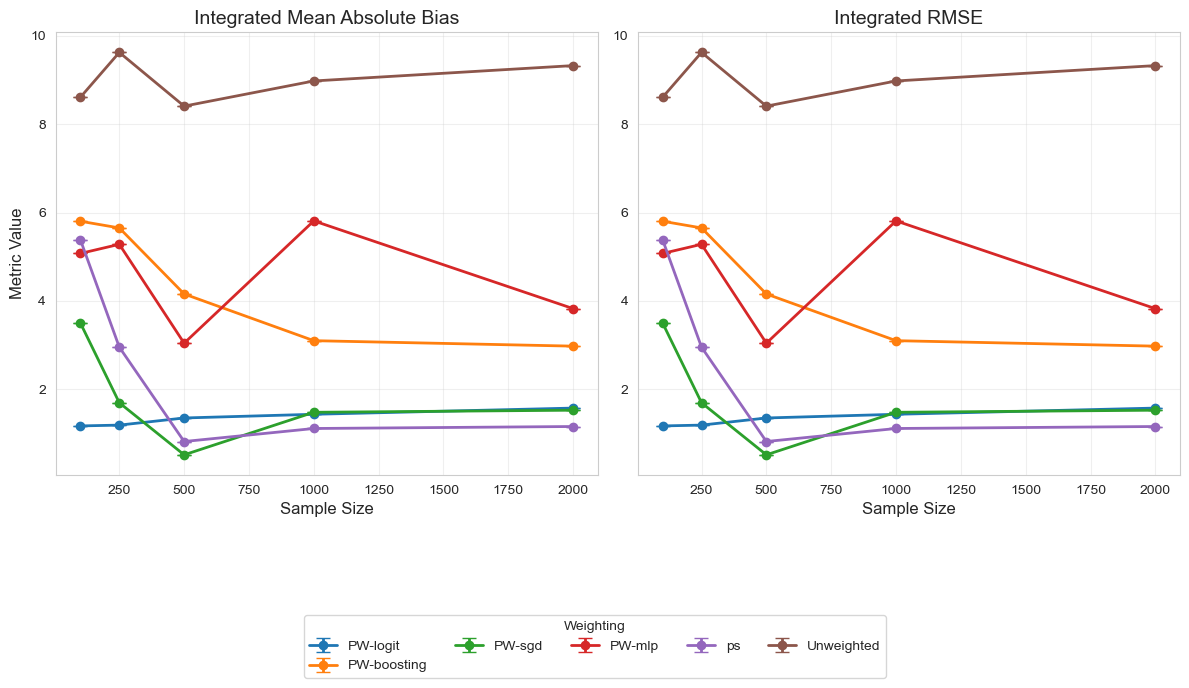

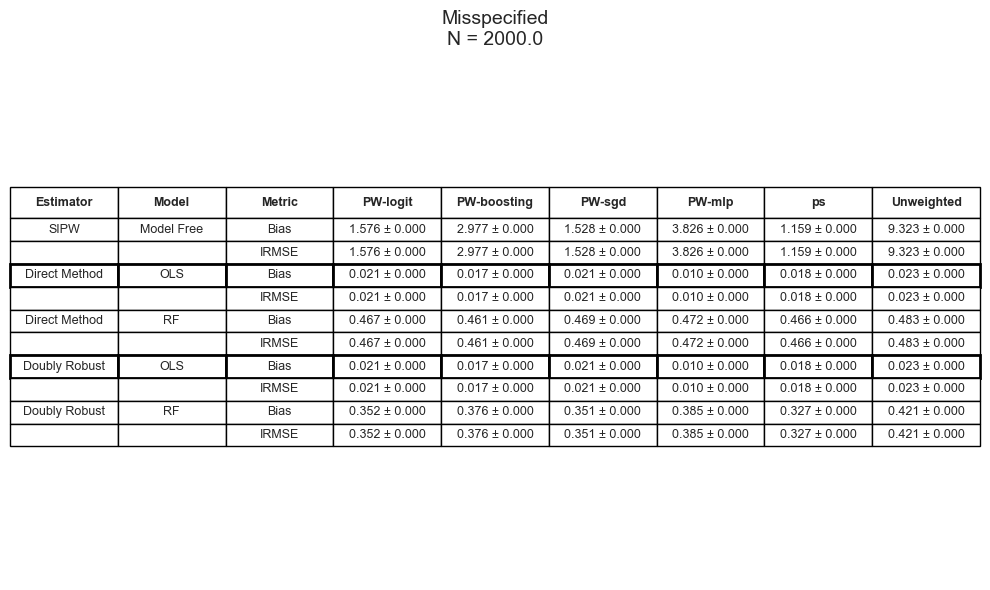

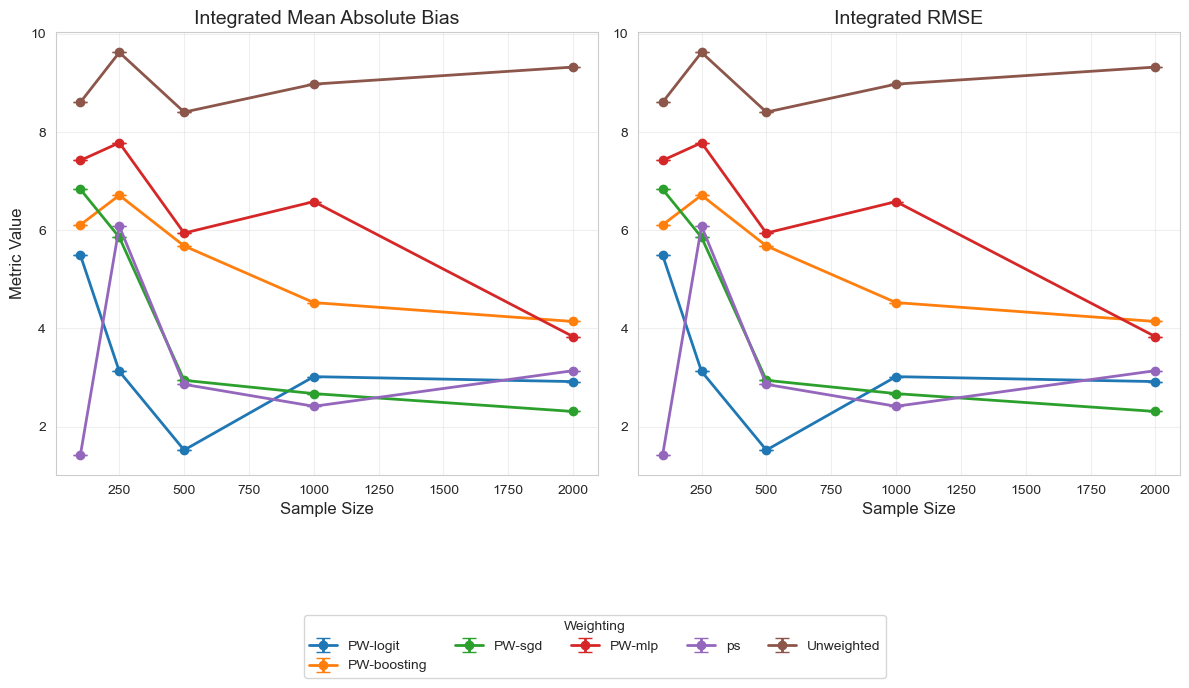

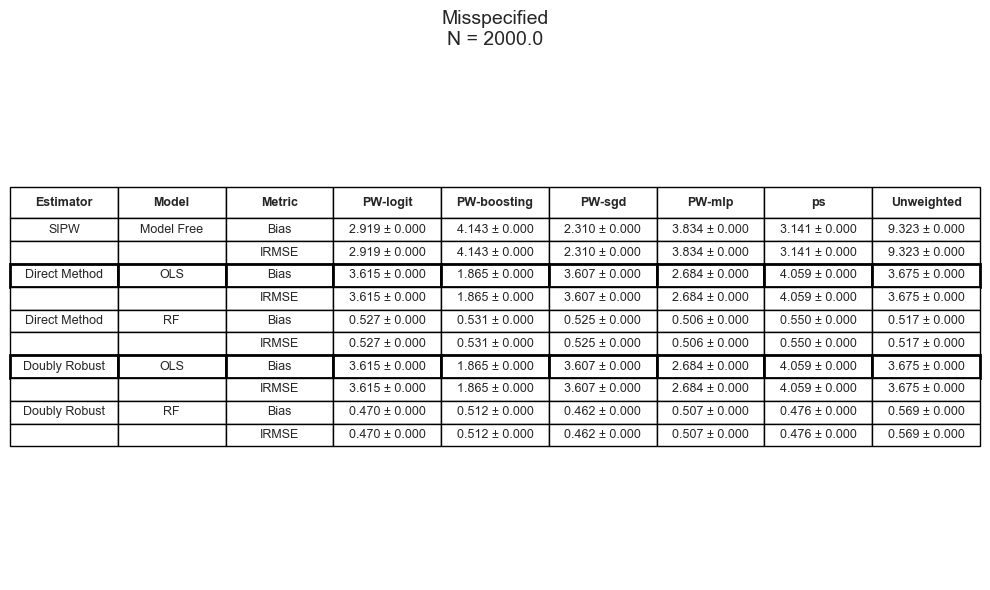

In [6]:

# Create visualizations for well-specified model
well_spec_results = results[~results['specification']]

fig_well, sum_well,table_well = evaluate_kang_schafer_simulation(
    well_spec_results, 
    create_kang_schafer_dgp(100, misspecified=False)
)


# Create visualizations for misspecified model
mis_spec_results = results[results['specification']]

fig_mis, sum_miss, table_miss = evaluate_kang_schafer_simulation(
    mis_spec_results, 
    create_kang_schafer_dgp(100, misspecified=True)
)


print("Simulation complete. Results and visualizations saved.")